### XIII. Outer Arm Replay Matrix

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import spyglass as nd
import pandas as pd
import statsmodels.api as sm
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection


# Here are the analysis tables specific to Shijie Gu
from spyglass.shijiegu.Analysis_SGU import (TrialChoice,
                                            TrialChoiceReplay,
                                            TrialChoiceRemoteReplay,
                                            RippleTimes,
                                            Decode,
                                            TrialChoiceReplayTransition,
                                            get_linearization_map,
                                            find_ripple_times,classify_ripples,classify_ripple_content)
from spyglass.shijiegu.PastFuture_Replay import (replay_in_categories,find_distinct_subset,proportion,
                                                 unravel_replay,count_replay_by_category,category_day)

[2023-06-20 11:33:51,392][INFO]: Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
20-Jun-23 11:33:51 Connecting shijiegu@lmf-db.cin.ucsf.edu:3306
[2023-06-20 11:33:51,453][INFO]: Connected shijiegu@lmf-db.cin.ucsf.edu:3306
20-Jun-23 11:33:51 Connected shijiegu@lmf-db.cin.ucsf.edu:3306
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.8/site-packages/position_tools/core.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d
20-Jun-23 11:33:52 Populate: Entry in DataAcquisitionDeviceSystem with primary keys {'data_acquisition_device_system': 'SpikeGadgets'} already exists.
20-Jun-23 11:33:52 Populate: Entry in DataAcquisitionDeviceAmplifier with primary keys {'data_acquisition_device_amplifier': 'Intan'} already exists.


In [3]:
#datafolder='/stelmo/shijie/recording_pilot/molly/plot/'
datafolder='/cumulus/shijie/recording_pilot/eliot/plot/'

In [4]:
pd.set_option('display.max_rows', None)

### Plot all inter replay interval

In [5]:
'''
nwb_copy_file_names=['molly20220415_.nwb','molly20220416_.nwb',
                     'molly20220417_.nwb','molly20220418_.nwb',
                     'molly20220419_.nwb','molly20220420_.nwb']


nwb_copy_file_names=['eliot20221016_.nwb','eliot20221017_.nwb',
       'eliot20221018_.nwb','eliot20221019_.nwb',
       'eliot20221020_.nwb','eliot20221021_.nwb',
       'eliot20221022_.nwb']
'''
nwb_copy_file_names=[
       'eliot20221020_.nwb','eliot20221021_.nwb',
       'eliot20221022_.nwb']


### Find outer well replays:

In [60]:
nwb_copy_file_name='eliot20221022_.nwb'

In [61]:
M=np.zeros((4,4))
trial_num=0

all_epochs=list((TrialChoice() & {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))
for e in all_epochs:
    try:
        T=pd.DataFrame((TrialChoiceRemoteReplay() & {'nwb_file_name':nwb_copy_file_name,
                                   'epoch':e}).fetch1('choice_reward_replay'))
    except:
        print(f'likely no data for {nwb_copy_file_name} epoch {e}')
        continue
    
    for t in T.index:
        current_well=int(T.loc[t,'current'])
        if len(T.loc[t,'replay_O'])==0:
            continue
        else:
            replay_O=np.concatenate(T.loc[t,'replay_O'])
            arm_replay_O=[int(i) for i in replay_O[~np.isnan(replay_O)] if i>=1 and i<=4]
            for a in arm_replay_O:
                M[current_well-1,a-1]+=1  

205.0


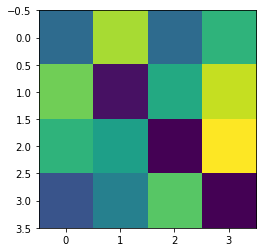

In [63]:
plt.imshow(M)
print(np.sum(M))

### Test load data

In [339]:
nwb_copy_file_name='molly20220420_.nwb'
epoch_num=8

In [357]:
transitions_all=(TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name,
                  'epoch':epoch_num}).fetch1('transitions')
transitions_all

array([[16.,  1.,  0.,  4.],
       [ 2., 15.,  0.,  2.],
       [ 0.,  0.,  8.,  1.],
       [ 0.,  0.,  0., 21.]])

In [340]:
transitions_all=(TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name,
                  'epoch':epoch_num}).fetch1('transitions')
transitions_all

array([[16.,  1.,  0.,  4.],
       [ 2., 15.,  0.,  2.],
       [ 0.,  0.,  8.,  1.],
       [ 0.,  0.,  0., 21.]])

In [334]:
T=pd.DataFrame((TrialChoiceReplayTransition() &
                {'nwb_file_name':nwb_copy_file_name,
                 'epoch':epoch_num}).fetch1('choice_reward_replay_transition'))
T

timestamp_H  Home   timestamp_O  OuterWellIndex replayed_transitions  \
1   1.650320e+09   1.0  1.650320e+09             3.0                   []   
4   1.650320e+09   1.0  1.650320e+09             3.0                   []   
5   1.650320e+09   1.0  1.650320e+09             2.0                   []   
6   1.650320e+09   1.0  1.650320e+09             4.0                   []   
7   1.650320e+09   1.0  1.650320e+09             1.0                   []   
8   1.650320e+09   1.0  1.650320e+09             3.0                   []   
9   1.650320e+09   1.0  1.650320e+09             4.0                   []   
10  1.650320e+09   1.0  1.650320e+09             1.0                   []   
11  1.650320e+09   1.0  1.650320e+09             3.0                   []   
12  1.650320e+09   1.0  1.650320e+09             2.0                   []   
13  1.650320e+09   1.0  1.650320e+09             4.0                   []   
14  1.650320e+09   1.0  1.650320e+09             1.0                   []   
15  1.650320e+09   1.0  1.650321e+09             3.0                   []   
16  1.650321e+09   1.0  1.650321e+09             4.0             [(2, 3)]   
17  1.650321e+09   1.0  1.650321e+09             2.0                   []   
18  1.650321e+09   1.0  1.650321e+09             3.0                   []   
19  1.650321e+09   1.0  1.650321e+09             1.0                   []   
20  1.650321e+09   1.0  1.650321e+09             4.0                   []   
21  1.650321e+09   1.0  1.650321e+09             1.0             [(1, 2)]   
22  1.650321e+09   1.0  1.650321e+09             3.0                   []   
23  1.650321e+09   1.0  1.650321e+09             2.0                   []   
24  1.650321e+09   1.0  1.650321e+09             4.0             [(1, 4)]   
25  1.650321e+09   1.0  1.650321e+09             1.0                   []   
26  1.650321e+09   1.0  1.650321e+09             3.0                   []   
27  1.650321e+09   1.0  1.650321e+09             4.0                   []   
28  1.650321e+09   1.0  1.650321e+09             2.0                   []   
29  1.650321e+09   1.0  1.650321e+09             3.0                   []   
30  1.650321e+09   1.0  1.650321e+09             4.0     [(4, 2), (2, 3)]   
31  1.650321e+09   1.0  1.650321e+09             1.0                   []   
32  1.650321e+09   1.0  1.650321e+09             4.0                   []   
33  1.650321e+09   1.0  1.650321e+09             3.0             [(1, 3)]   
34  1.650321e+09   1.0  1.650321e+09             1.0             [(2, 1)]   
35  1.650321e+09   1.0  1.650321e+09             4.0                   []   
36  1.650321e+09   1.0  1.650321e+09             3.0                   []   
37  1.650321e+09   1.0  1.650321e+09             2.0             [(1, 2)]   
38  1.650321e+09   1.0  1.650321e+09             4.0                   []   
39  1.650321e+09   1.0  1.650321e+09             1.0                   []   
40  1.650321e+09   1.0  1.650321e+09             3.0                   []   
41  1.650321e+09   1.0  1.650321e+09             4.0                   []   
42  1.650321e+09   1.0  1.650321e+09             2.0                   []   
43  1.650321e+09   1.0  1.650321e+09             1.0                   []   
44  1.650321e+09   1.0  1.650321e+09             3.0                   []   
45  1.650321e+09   1.0  1.650321e+09             4.0                   []   
46  1.650321e+09   1.0  1.650321e+09             2.0                   []   
47  1.650321e+09   1.0  1.650321e+09             1.0             [(3, 4)]   
48  1.650321e+09   1.0  1.650321e+09             4.0                   []   
49  1.650321e+09   1.0  1.650321e+09             2.0                   []   
50  1.650321e+09   1.0  1.650321e+09             3.0                   []   
51  1.650321e+09   1.0  1.650321e+09             4.0                   []   
52  1.650321e+09   1.0  1.650321e+09             1.0                   []   
53  1.650321e+09   1.0  1.650321e+09             3.0                   []   
5

In [316]:
T.loc[11,:]

timestamp_H                                             1650477700.547073
Home                                                                  1.0
timestamp_O                                             1650477710.329101
OuterWellIndex                                                        4.0
replayed_transitions                                                   []
rewardNum                                                             2.0
ripple_H                [[[1650477700.7430654, 1650477700.8490653]], [...
ripple_O                [[[1650477715.8290586, 1650477715.8790586], [1...
replay_H                  [[0], [0], [0], [nan, 5.0], [5], [0], [0], [0]]
ripple_peak_H                                                          []
replay_O                                 [[4.0, nan, 4.0, nan], [3], [4]]
ripple_peak_O                                                          []
Name: 11, dtype: object

### Plot sequence

In [85]:
seq1=[2,4,1,3];
seq2=[3,4,2,1];
seq3=[1,2,3,4];

rev1=[2,3,1,4];
rev2=[2,4,3,1];
rev3=[1,4,3,2];

seqs=np.vstack((seq1,seq2,seq3,rev1,rev2,rev3))
orders=['seq1','seq2','seq3','rev1','rev2','rev3']

In [86]:
trans_seq={}
for i in range(4):
    for j in range(4):
        if i!=j:
            trans_seq[(i+1,j+1)]=[]
            
for seq_ind in range(np.shape(seqs)[0]):
    seq=seqs[seq_ind]
    for i in range(len(seq)):
        trans_seq[(seq[i],seq[(i+1)%4])].append(seq_ind+1)

In [87]:
trans_seq

{(1, 2): [3, 5],
 (1, 3): [1, 2],
 (1, 4): [4, 6],
 (2, 1): [2, 6],
 (2, 3): [3, 4],
 (2, 4): [1, 5],
 (3, 1): [4, 5],
 (3, 2): [1, 6],
 (3, 4): [2, 3],
 (4, 1): [1, 3],
 (4, 2): [2, 4],
 (4, 3): [5, 6]}

In [397]:
nwb_copy_file_name='molly20220420_.nwb'
epoch_num=8

In [405]:
def find_seq_count_epoch(nwb_copy_file_name,epoch_num):
    transitions_all=(TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name,
                  'epoch':epoch_num}).fetch1('transitions')

    seq_count=np.zeros(6)
    pairs=list(trans_seq.keys())
    for p in pairs:
        c=transitions_all[p[0]-1,p[1]-1]
        seqs=trans_seq[p]
        seq_count[seqs[0]-1]+=c
        seq_count[seqs[1]-1]+=c
        
    return seq_count

In [462]:
seq_count=[]
sum_count=[]
nwb_copy_file_names=['molly20220415_.nwb','molly20220416_.nwb',
                     'molly20220417_.nwb','molly20220418_.nwb',
                     'molly20220419_.nwb','molly20220420_.nwb']

for nwb_copy_file_name in nwb_copy_file_names:
    all_epochs=list((TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))

    seq_count_day=np.zeros(6)
    for epoch_num in all_epochs:
        seq_count_epoch=find_seq_count_epoch(nwb_copy_file_name,epoch_num)
        seq_count_day=seq_count_day+seq_count_epoch
    sum_count.append(np.sum(seq_count_day))
    seq_count_day=seq_count_day/np.sum(seq_count_day)
    seq_count.append(seq_count_day)    
seq_count=np.array(seq_count)

Text(0, 0.5, 'occurance rate')

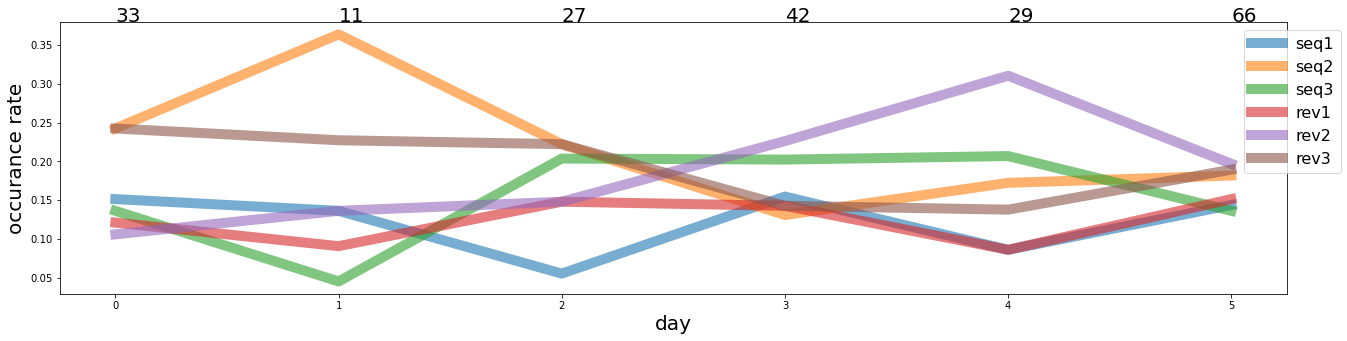

In [470]:
fig,axes=plt.subplots(1,1,figsize=(22, 5))
lines=[]
for i in range(6):
    line1,=plt.plot(seq_count[:,i],color='C'+str(i),alpha=0.6,label=orders[i],linewidth=10)
    lines.append(line1)
y3=axes.get_ylim()
for i in range(6):
    plt.text(i,y3[1],int(sum_count[i]/2),fontsize=20)
axes.legend(handles=lines,fontsize=16,bbox_to_anchor=(1.05, 1))

#axes.set_title('pairwise replays by sequences by day',fontsize=20,)
axes.set_xlabel('day',fontsize=20,)
axes.set_ylabel('occurance rate',fontsize=20,)

In [479]:
seq_count=[]
dates=[]
nwb_copy_file_names=['molly20220415_.nwb','molly20220416_.nwb',
                     'molly20220417_.nwb','molly20220418_.nwb',
                     'molly20220419_.nwb','molly20220420_.nwb']
for nwb_copy_file_name in nwb_copy_file_names:
    all_epochs=list((TrialChoiceReplayTransition() & 
                 {'nwb_file_name':nwb_copy_file_name}).fetch('epoch'))

    seq_count_day=np.zeros(6)
    for epoch_num in all_epochs:
        seq_count_epoch=find_seq_count_epoch(nwb_copy_file_name,epoch_num)
        if np.sum(seq_count_epoch)>14:
            seq_count_epoch=seq_count_epoch/np.sum(seq_count_epoch)
            seq_count.append(seq_count_epoch)
            dates.append(int(nwb_copy_file_name[5:13]))
seq_count=np.array(seq_count)
dates=np.array(dates)

Text(0.5, 0, 'session')

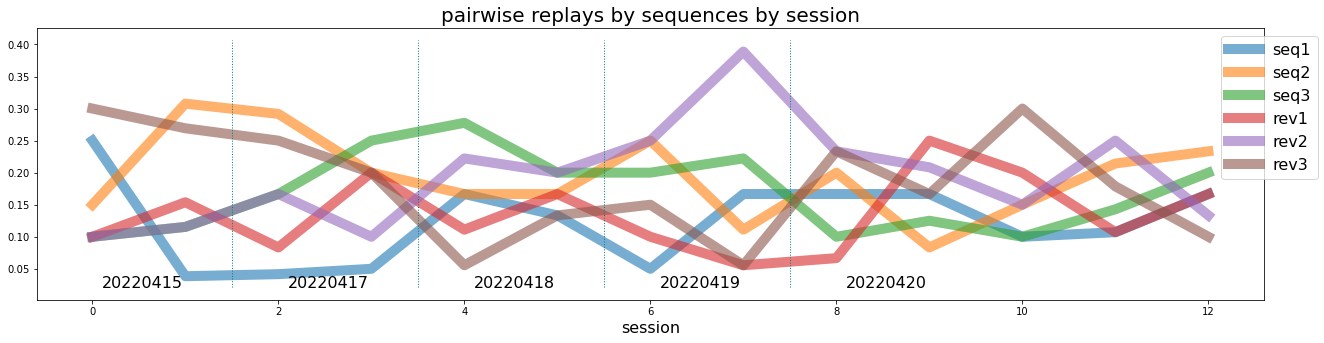

In [480]:
fig,axes=plt.subplots(1,1,figsize=(22, 5))
lines=[]
for i in range(6):
    line1,=plt.plot(seq_count[:,i],alpha=0.6,color='C'+str(i),label=orders[i],linewidth=10)
    lines.append(line1)
    
day_change=np.argwhere(np.diff(dates)).ravel()+1
y3=axes.get_ylim()
axes.text(0.1,y3[0],dates[0],fontsize=16)
for t in day_change:
    axes.plot([t-0.5,t-0.5],y3,':',linewidth=1,color='teal')
    axes.text(t+0.1,y3[0],dates[t],fontsize=16)
    
axes.legend(handles=lines,fontsize=16,bbox_to_anchor=(1.05, 1))
axes.set_title('pairwise replays by sequences by session',fontsize=20,)
axes.set_xlabel('session',fontsize=16,)